# Image Augmentation

## Importing Dependencies

In [1]:
# standard python modules
import os # for working with directories
import os.path # for working with paths
import time
import gc

#core python modules
from PIL import Image # for loading and saving images
from scipy import ndimage # for core image processing namely, rotate, blur and shift

import numpy as np # for all other maths operations 
import matplotlib.pyplot as plt # for image visualization
import pickle

#custom project modules
from dataset import get_files 
from dataset import load_dataset, visualize_dataset, sample_dataset,prep_dataset
from ModelUtils import convert_time



### Loading MNIST dataset form binary data file

In [2]:
dataset_size_in_per = 100

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")



Sample Size : 100%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (60000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (60000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (10000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (10000, 1)


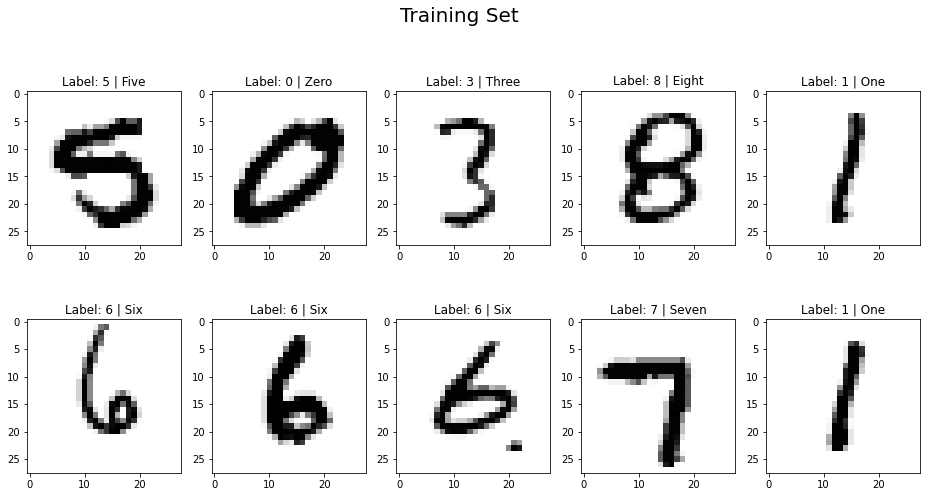

In [3]:
visualize_dataset(train_x_orig, train_y_orig, dataset = "mnist", dataset_type = "training")

## Geometric Transformations

(5, 28, 28) (5, 1)


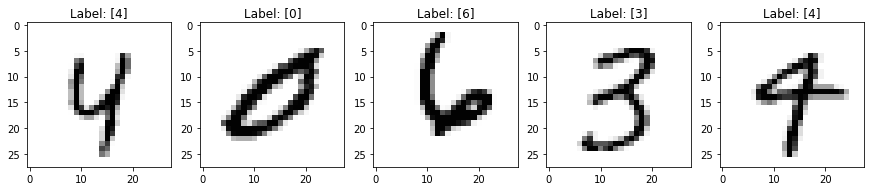

In [7]:
ind = np.random.randint(10,10000)
imgs = train_x_orig[ind:ind+5]
lbls = train_y_orig[ind:ind+5]
print(imgs.shape, lbls.shape)
fig = plt.figure(figsize=(15, 5))
axes= fig.subplots(1, imgs.shape[0])
for i, img in enumerate(imgs):
    axes[i].imshow(img, cmap = "Greys")
    axes[i].set_title("Label: %s"%lbls[i])


### Rotating Image

In [8]:
#rotating and rotating+zooming

def rotate_images(images,labels, save_image = False):
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/rotated/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    rotated_images = []
    
    for i in range(m):    
        # randomly selecting angle between the range -45 to -15 and 15 to 45
        pos_angle = np.random.randint(low = 0, high = 60)
        neg_angle = np.random.randint(low = -60, high = 0)
        angle = np.random.choice([pos_angle,neg_angle])

        rotated_img = ndimage.rotate(images[i], angle, reshape=False, mode = "nearest")
        
        if(save_image):
            img = Image.fromarray((rotated_img * 255).astype(np.uint8))
            img.save(path + str(np.squeeze(labels[i]))+"_rotated_"+str(i+1)+".jpg")
            
        rotated_images.append(rotated_img)
    
    return np.asarray(rotated_images), labels

   
    

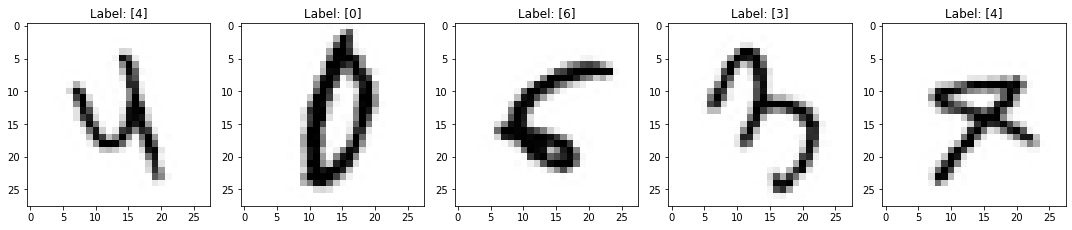

In [22]:
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(1, imgs.shape[0])

rotated_images, labels = rotate_images(imgs,lbls, save_image = False)
for i in range(lbls.shape[0]):
    axes[i].imshow(rotated_images[i], cmap='Greys')
    axes[i].set_title("Label: %s"%labels[i])
#     axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


### Blurring using different filters

In [23]:
#blurring using Gaussian Filter
def blur_images(images, labels, filter_mode = "random", random_filter = False, save_image = False):
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/blurred/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    blurred_images = []

    for i in range(m):    
        
        if random_filter:
            filters = ['gaussian', 'maximum', 'minimum', 'median', 'uniform']
            filter_mode = np.random.choice(filters)
            
        if filter_mode == "gaussian":
            sig = np.random.uniform(low = 0, high = 2.5)
            blurred_img = ndimage.gaussian_filter(images[i], sigma=sig,  mode = "nearest")

        elif filter_mode =="maximum":
            s = np.random.uniform(low = 0, high = 4)
            blurred_img = ndimage.maximum_filter(images[i], size= s,  mode = "nearest")

        elif filter_mode == "minimum":
            s = np.random.uniform(low = 0, high = 4)
            blurred_img = ndimage.minimum_filter(images[i], size= s,  mode = "nearest")

        elif filter_mode == "median":
            s = np.random.randint(low = 1, high = 6)
            blurred_img = ndimage.median_filter(images[i], size= s,  mode = "nearest")

        elif filter_mode == "uniform":
            s = np.random.uniform(low = 1, high = 6)
            blurred_img = ndimage.uniform_filter(images[i], size= s, mode = "nearest")

        else:
            raise ValueError("filter mode should only be 'gaussian', 'maximum', 'minimum', 'median', or 'uniform'")
        
        if(save_image):
                img = Image.fromarray((blurred_img * 255).astype(np.uint8))
                img.save(path + str(np.squeeze(labels[i]))+"_blurred_"+filter_mode+"_"+str(i+1)+".jpg")

        blurred_images.append(blurred_img)
    
    return np.asarray(blurred_images), labels


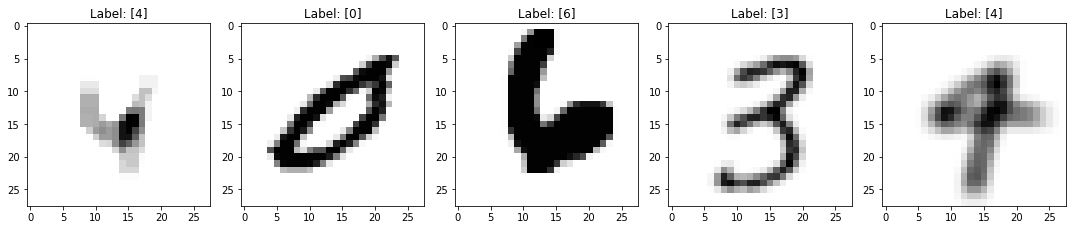

In [32]:
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(1, imgs.shape[0])

blurred_images, labels = blur_images(imgs,lbls, filter_mode = "uniform",random_filter = True, save_image = False)

for i in range(lbls.shape[0]):
    axes[i].imshow(blurred_images[i], cmap='Greys')
    axes[i].set_title("Label: %s"%labels[i])
#     axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


### Shifting Image

In [33]:
#Shifting image
def shift_images(images,labels, shifting ="both", save_image = False):
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/shifted/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    shifted_images = []
    low = -7
    high = 7
    
    for i in range(m):    
         # randomly selecting angle between the range -45 to -15 and 15 to 45
        
        if shifting == "horizontal":
            xs = 0
            ys = np.random.uniform(low, high)
            
            
        elif shifting == "vertical":
            ys = 0
            xs = np.random.uniform(low , high)
            
        elif shifting == "both":
            xs = np.random.uniform(low , high)
            ys = np.random.uniform(low , high)
        else:
            raise ValueError("Shifting should only be 'horizontal', 'vertical', or 'both'")
            

        shifted_img = ndimage.shift(images[i], shift= (xs,ys), mode = "nearest")
        
        if(save_image):
            img = Image.fromarray((shifted_img * 255).astype(np.uint8))
            img.save(path + str(np.squeeze(labels[i]))+"_shifted_"+shifting+"_"+str(i+1)+".jpg")
            
        shifted_images.append(shifted_img)
    
    return np.asarray(shifted_images), labels

   

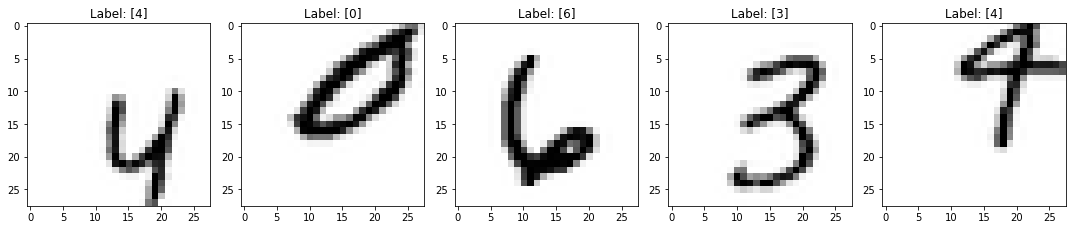

In [37]:
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(1, imgs.shape[0])

shifted_images, labels = shift_images(imgs,lbls, shifting ="both", save_image = False)

for i in range(lbls.shape[0]):
    axes[i].imshow(shifted_images[i], cmap='Greys')
    axes[i].set_title("Label: %s"%labels[i])
#     axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


### Cropping and Padding

In [38]:
#cropping image
def crop_and_pad_images(images, labels, crop_center = False, save_image = False):
   
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/cropped_and_padded/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    cropped_images = []
    low = 4
    high = 10
    
    for i in range(m):    
        lx, ly = images[i].shape
        cropped_image = np.zeros((lx,ly))
        cropped_image.fill(0) #padding with pixelvalue; 255 for white and 0 for black padding
        if crop_center: # this will work as zoom and crop
            # randomly selecting  the range for central cropping
            c = np.random.randint(low = 4, high = 10)
            cropped_image[lx // c: - lx // c, ly // c: - ly // c] = np.copy(images[i][lx // c: - lx // c, ly // c: - ly // c])
        else: 
            # randomly selecting  the range for cropping across different axis
            clx = np.random.randint(low, high )
            crx= np.random.randint(low, high )
            cly = np.random.randint(low, high )
            cry = np.random.randint(low, high )
            cropped_image[lx // clx: - lx // crx, ly // cly: - ly // cry] = np.copy(images[i][lx // clx: - lx // crx, ly // cly: - ly // cry])

        if(save_image):
            img = Image.fromarray((cropped_image * 255).astype(np.uint8))
            img.save(path + str(np.squeeze(labels[i]))+"_cropped_"+str(i+1)+".jpg")
            
        cropped_images.append(cropped_image)
    
    return np.asarray(cropped_images), labels


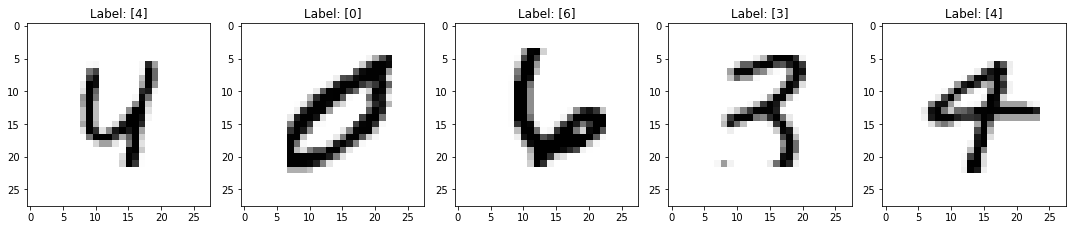

In [42]:
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(1, imgs.shape[0])

cropped_images, labels = crop_and_pad_images(imgs,lbls,crop_center = False, save_image = False)

for i in range(lbls.shape[0]):
    axes[i].imshow(cropped_images[i], cmap='Greys')
    axes[i].set_title("Label: %s"%labels[i])
#     axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


### Zoom

In [43]:
#zooming image
def zoom_images(images, labels, save_image = False):
    m = labels.shape[0]
    if save_image:
        path = "dataset/mnist_augmented/zommed/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    zoomed_images = []
    low = 4
    high = 10
    
    for i in range(m):    
        lx, ly = images[i].shape
        clx = np.random.randint(low, high )
        crx= np.random.randint(low, high )
        cly = np.random.randint(low, high )
        cry = np.random.randint(low, high )
        cropped= np.copy(images[i][lx // clx: - lx // crx, ly // cly: - ly // cry])
        
        zoomed = Image.fromarray((cropped).astype(np.uint8)).resize((lx,ly))
        
        if(save_image):
            zoomed.save(path + str(np.squeeze(labels[i]))+"_cropped_"+str(i+1)+".jpg")
            
        zoomed_images.append(np.asarray(zoomed))
    
    return np.asarray(zoomed_images), labels


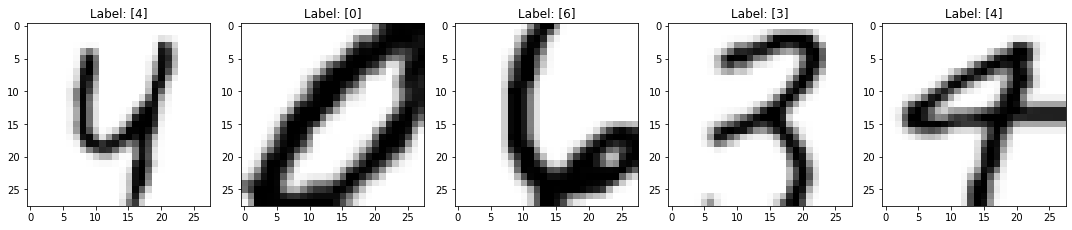

In [48]:
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(1, imgs.shape[0])

cropped_images, labels = zoom_images(imgs,lbls, save_image = False)

for i in range(lbls.shape[0]):
    axes[i].imshow(cropped_images[i], cmap='Greys')
    axes[i].set_title("Label: %s"%labels[i])
#     axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


### Flip Image

In [ ]:
#Flipping image


def horizontal_flip_images(images,labels, save_image = False):
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/h_flipped/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    flipped_images = []
    
    for i in range(m):    
        flip_h = np.fliplr(images[i])

        if(save_image):
#             https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type
            img = Image.fromarray((flip_h * 255).astype(np.uint8))
            img.save(path + str(np.squeeze(labels[i]))+"_hFlipped_"+str(i+1)+".jpg")
            
        flipped_images.append(flip_h)
    
    return np.asarray(flipped_images), labels



In [ ]:
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(1, imgs.shape[0])

flipped_images, labels = horizontal_flip_images(imgs,lbls,save_image = False)

for i in range(lbls.shape[0]):
    axes[i].imshow(flipped_images[i], cmap='Greys')
    axes[i].set_title("Label: %s"%labels[i])
#     axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


## Accumulating all the Geometric Transformation in one place

In [ ]:
def augment_img(images_orig, labels, horizontal_flip = False, crop_and_pad = False, rotate = False, shift = False, blur = False, zoom = False, save_images = False, include_original = False):
    
    m = labels.shape[0]
    
    augmented_images = np.copy(images_orig)
    augmented_labels = np.copy(labels)

    #horizontal flipping
    if horizontal_flip:
        flipped_images, flipped_labels = horizontal_flip_images(images_orig, labels, save_image = save_images)
        augmented_images = np.concatenate((augmented_images, flipped_images), axis = 0)
        augmented_labels = np.concatenate((augmented_labels, flipped_labels), axis = 0)
        flipped_images, flipped_labels = 0,0
    #random cropping and padding
    if crop_and_pad:
        cropped_images, cropped_labels = crop_and_pad_images(images_orig, labels, save_image = save_images)
        augmented_images = np.concatenate((augmented_images, cropped_images), axis = 0)
        augmented_labels = np.concatenate((augmented_labels, cropped_labels), axis = 0)
        cropped_images, cropped_labels = 0,0
    #random rotating
    if rotate:
        rotated_images, rotated_labels = rotate_images(images_orig, labels, save_image = save_images)
        augmented_images = np.concatenate((augmented_images, rotated_images), axis = 0)
        augmented_labels = np.concatenate((augmented_labels, rotated_labels), axis = 0)
        rotated_images, rotated_labels = 0,0
    #random shifting
    if shift:
        shifted_images, shifted_labels = shift_images(images_orig,labels, shifting ="both", save_image = save_images)
        augmented_images = np.concatenate((augmented_images, shifted_images), axis = 0)
        augmented_labels = np.concatenate((augmented_labels, shifted_labels), axis = 0)
        shifted_images, shifted_labels = 0,0
    #random blurring
    if blur:
        blurred_images, blurred_labels = blur_images(images_orig, labels, random_filter = True, save_image =save_images)
        augmented_images = np.concatenate((augmented_images, blurred_images), axis = 0)
        augmented_labels = np.concatenate((augmented_labels, blurred_labels), axis = 0)
        blurred_images, blurred_labels = 0,0
        
        #random blurring
    if zoom:
        zoomed_images, zoomed_labels = zoom_images(images_orig, labels, save_image =save_images)
        augmented_images = np.concatenate((augmented_images, zoomed_images), axis = 0)
        augmented_labels = np.concatenate((augmented_labels, zoomed_labels), axis = 0)
        zoomed_images, zoomed_labels = 0,0
    
    #suffeling all the images
    augmented_images, augmented_labels = sample_dataset(augmented_images, augmented_labels, size_in_per = 100)
    
     
    if include_original:
        return augmented_images, augmented_labels
    else:
        return augmented_images[m::], augmented_labels[m:]
    

In [ ]:
augmented_images, augmented_labels = augment_img(train_x_orig, train_y_orig, 
                                                 horizontal_flip = False, 
                                                 crop_and_pad = True, 
                                                 rotate = True, shift = True, 
                                                 blur = True, 
                                                 zoom = True,
                                                 save_images = False, 
                                                 include_original = False)

In [ ]:
print(augmented_images.shape, augmented_labels.shape)

fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, 5)

for i in range(5):
    axes[i].imshow(augmented_images[i], cmap='gray')
    axes[i].set_title("Label: %s"%augmented_labels[i])
    axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()

# visualize_dataset(augmented_images, augmented_labels, dataset = "mnist", dataset_type = "training")


## Generating large volume of data

### Generating minibatches

In [ ]:
def generate_minibatches(X, Y, minibatch_size=64, seed=1):
  
    np.random.seed(seed)  # varying the seed value so that the minibatchs become random in each epoch
    m = Y.shape[0]  # number of training examples
    minibatches = []

    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :]
    shuffled_Y = Y[permutation, :]

    # Partition (shuffled_X, shuffled_Y) except for the last batch
    num_complete_minibatches = np.floor(m / minibatch_size).astype(int)  # number of mini batches of size minibatch_size
    for k in range(0, num_complete_minibatches):
        minibatch_X = shuffled_X[k * minibatch_size: (k + 1) * minibatch_size, :, :]
        minibatch_Y = shuffled_Y[k * minibatch_size: (k + 1) * minibatch_size, :]
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)

    # Last batch (last minibatch <= minibatch_size)
    if m % minibatch_size != 0:
        minibatch_X = shuffled_X[num_complete_minibatches * minibatch_size: m, :, :]
        minibatch_Y = shuffled_Y[num_complete_minibatches * minibatch_size: m, :]
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)
    del shuffled_X, shuffled_Y
    return minibatches



### Data Generator

In [ ]:
def get_readable_datasize(orig_size):
    size = 0
    if orig_size >= 1e6:
        size = int(orig_size//1e6) if orig_size % 1e6 == 0 else orig_size/1e6
        readable_size = str(size)+"M"
    elif orig_size >=1e3:
        size = int(orig_size//1e3) if orig_size % 1e3 == 0 else orig_size/1e3
        readable_size = str(size)+"K"
    else:
        readable_size = str(orig_size)
    
    return readable_size

In [ ]:
def save_generated_data(path, batch_no, data):
    if not os.path.exists(path):
        os.makedirs(path)  # creating required directories recursively

    filename = "batch_" + str(batch_no)
    with open(path + filename, 'wb') as output_file:
        pickle.dump(data, output_file)

In [ ]:
def data_generator(X_orig, Y_orig, batch_size = 64, aug_count = 1, verbose = 0, pre_process_data = False):
    #initializing the variables
    seed = 1
    path = "dataset/augmented_data/"
    aug_tic = time.time() # for calculating entire augmentation time

    print("Generating %s Augmented images..."%(get_readable_datasize(X_orig.shape[0] * aug_count * 5)))
    
    for i in range(1, aug_count+1):
        seed += 1
        time_augmented = 0
        batch_times = []
        aug_images = np.copy(X_orig[0:1,:,:])
        aug_labels = np.copy(Y_orig[0:1,:])
      
        if verbose > 0:
            print("\nAugmentation Count %d/%d"%(i,aug_count))
        
        minibatches = generate_minibatches(X_orig, Y_orig, batch_size, seed)
        total_minibatches = len(minibatches)
        
        for ind, minibatch in enumerate(minibatches):
            batch_toc = time.time() # for calculating time of an epoch cycle
            
            #retriving minibatch of X and Y from training set
            (minibatch_X, minibatch_Y) = minibatch
            
            aug_images_batch, aug_labels_batch = augment_img(minibatch_X, minibatch_Y,
                                                             crop_and_pad = True,
                                                             rotate = True,
                                                             shift = True,
                                                             blur = True,
                                                             zoom = True)
            
            aug_images = np.concatenate((aug_images, aug_images_batch), axis = 0)
            aug_labels = np.concatenate((aug_labels, aug_labels_batch), axis = 0)
            
            
            if verbose > 1:
            # Calculating Augmentation time for each batch 
                batch_tic = time.time()
                batch_times.append(batch_tic - batch_toc)
                time_augmented = np.sum(batch_times)
            
                #calculating Augmentation progress
                per = ((ind+1) / total_minibatches) * 100
                inc = int(per // 10) * 2
                           
                print ("%d/%d [%s>%s %.0f%%] - %.2fs"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_augmented),end='\r')
            
        #----------------------------------------------batch ends-------------------------------------------
        if pre_process_data:
            aug_data = prep_dataset(aug_images[1:], aug_labels[1:], num_class = 10)
        else:    
            aug_data = (aug_images[1:], aug_labels[1:])

        save_generated_data(path, batch_no = i, data = aug_data)
        del aug_data,aug_images,aug_labels
        
        if verbose > 1:
            time_per_batch = int(np.mean(batch_times)*1000)
            print ("%d/%d [%s 100%%] - %.2fs %dms/step"%(total_minibatches, total_minibatches, '=' * 20, time_augmented, time_per_batch ),end='\r')
                
    #-------------------------------------------Total Augmentation ends-----------------------------------------------
    gc.collect()
    
    if verbose > 1:
        #calculating entire Augmentation time
        hrs, mins, secs , ms = convert_time((time.time() - aug_tic)*1000)
        print("\n\nTotal Augmentation Time = %dhr %dmins %dsecs %.2fms"%(hrs, mins, secs, ms))

    

In [ ]:
data_generator(train_x_orig, train_y_orig, batch_size = 2048, aug_count = 1, verbose = 2, pre_process_data = True)


In [ ]:
def load_augmented_data():
    path = "dataset/augmented_data/"
    
    if not os.path.exists(path):
            raise ValueError("Given folder doesnot exist")

    file_names = get_files(path)
    print(file_names)
    for ind,file in enumerate(file_names):
        fname = path + file
        try:
            with open(fname, 'rb') as input_file:
                image_batch, label_batch = pickle.load(input_file)
        except(OSError, IOError) as e:
            print(e)

        if ind == 0:
            aug_images = image_batch
            aug_labels = label_batch
        else:
            aug_images = np.concatenate((aug_images, image_batch), axis = 1)
            aug_labels = np.concatenate((aug_labels, label_batch), axis = 1)
        
        del image_batch, label_batch
    return aug_images, aug_labels


    


In [ ]:
path = "dataset/augmented_data/"
aug_images, aug_labels = load_augmented_data()
print(aug_images.shape,aug_labels.shape)

In [ ]:
# def data_generator(X_orig, Y_orig, batch_size = 64, aug_count = 1, verbose = 0, pre_process_data = False):
#     #initializing the variables
#     seed = 1
#     aug_images = np.copy(X_orig[0:1,:,:])
#     aug_labels = np.copy(Y_orig[0:1,:])
   
#     aug_toc = time.time() # for calculating entire augmentation time

#     print("Generating %s Augmented images..."%(get_readable_datasize(X_orig.shape[0] * aug_count * 4)))
    
#     for i in range(1, aug_count+1):
#         seed += 1
#         time_augmented = 0
#         batch_times = []
      
#         if verbose > 0:
#             print("\nAugmentation Count %d/%d"%(i,aug_count))
        
#         minibatches = generate_minibatches(X_orig, Y_orig, batch_size, seed)
#         total_minibatches = len(minibatches)
        
#         for ind, minibatch in enumerate(minibatches):
#             batch_toc = time.time() # for calculating time of an epoch cycle
            
#             #retriving minibatch of X and Y from training set
#             (minibatch_X, minibatch_Y) = minibatch
            
#             aug_images_batch, aug_labels_batch = augment_img(minibatch_X, minibatch_Y,
#                                                              crop_and_pad = True,
#                                                              rotate = True,
#                                                              shift = True,
#                                                              blur = True,
#                                                              zoom = True,
#                                                              save_images = False,
#                                                              include_original = False)
            
#             aug_images = np.concatenate((aug_images, aug_images_batch), axis = 0)
#             aug_labels = np.concatenate((aug_labels, aug_labels_batch), axis = 0)
            
#             if verbose > 1:
#             # Calculating Augmentation time for each batch 
#                 batch_tic = time.time()
#                 batch_times.append(batch_tic - batch_toc)
#                 time_augmented = np.sum(batch_times)
            
#                 #calculating Augmentation progress
#                 per = ((ind+1) / total_minibatches) * 100
#                 inc = int(per // 10) * 2
                           
#                 print ("%d/%d [%s>%s %.0f%%] - %.2fs"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_augmented),end='\r')
            
#         #----------------------------------------------batch ends-------------------------------------------
       
#         if verbose > 1:
#             time_per_batch = int(np.mean(batch_times)*1000)
#             print ("%d/%d [%s 100%%] - %.2fs %dms/step"%(total_minibatches, total_minibatches, '=' * 20, time_augmented, time_per_batch ),end='\r')
                
#     #-------------------------------------------Total Augmentation ends-----------------------------------------------
#     if verbose > 1:
#         aug_tic = time.time() # for calculating entire Augmentation time
#         hrs, mins, secs , ms = convert_time((aug_tic - aug_toc)*1000)
#         print("\n\nTotal Augmentation Time = %dhr %dmins %dsecs %.2fms"%(hrs, mins, secs, ms))

#     if pre_process_data:
#         return prep_dataset(aug_images[1:], aug_labels[1:], num_class = 10)
#     else:    
#         return aug_images[1:], aug_labels[1:]

In [ ]:
# # generating data in offline mode
# # to generate data in online mode call this function inside an epoch with pre_process_data = True
# augmented_images, augmented_labels = data_generator(train_x_orig, train_y_orig, batch_size = 2048, aug_count = 2, verbose = 2, pre_process_data = False)

# print("Data\t\t\t","Before Augmentation\t","After Augmentation")
# print("=================================================================")
# print("Training Set Images:\t" + str(train_x_orig.shape)+"\t\t"+ str(augmented_images.shape))
# print("Training Set Labels:\t" + str(train_y_orig.shape)+"\t\t"+ str(augmented_labels.shape))
# print("=================================================================")


In [ ]:
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, 5)

for i in range(5):
    axes[i].imshow(augmented_images[i], cmap='gray')
    axes[i].set_title("Label: %s"%augmented_labels[i])
    axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()

## Loading images from the directory

In [ ]:

def load_images_from_file(path):
    #checking for the validity of the path
    if not os.path.exists(path):
            raise ValueError("Given folder doesnot exist")

    image_names = sorted(get_files(path))
    images = []
    lbls = []
    for image_name in image_names:
        fname = path + image_name
        image_data = np.asarray(Image.open(fname).resize((28,28)).convert('L')).reshape(28,28)
        if image_data[1,1] > 250: #if background is white, reversing the fore and background color
            image_data = 255 - image_data
        images.append(image_data.tolist())
        lbls.append(image_name[0])

    real_images = np.asarray(images)
    labels = np.asarray(lbls)
    
    return real_images, labels



In [ ]:

image_path = "Sample Images/"
images, labels = load_images_from_file(path = image_path)
# print(images.shape)    


imgs = images[5:10]
lbls = labels[5:10]

print(imgs.shape, lbls.shape)
fig = plt.figure(figsize=(10, 3))
axes= fig.subplots(1, imgs.shape[0])
for i, img in enumerate(imgs):
    axes[i].imshow(img, cmap = "gray")
    axes[i].set_title("Label: %s"%lbls[i])
print(imgs[1][1,1])